In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import yaml
import cv2
import random
from datetime import datetime
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from glob import glob
from sklearn.model_selection import train_test_split
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

%matplotlib inline

plt.style.use('seaborn')

In [21]:
with open('param.yaml') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

In [22]:
seed = cfg['seed']

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(seed)

In [23]:
now = datetime.now()
time = str(now.time()).replace(':', '')[0:6]
date = str(now.date()).replace('-', '')[0:8]

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size=512
epoch=10
patience=5
lr=0.0001
input_size=28
class_num=2
seed=42

print(f'device : {device}\ntorch_version : {torch.__version__}')

device : cuda
torch_version : 1.13.0


In [25]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_album_transform = albumentations.Compose([
    albumentations.Resize(224, 224),
    # albumentations.HorizontalFlip(p=0.5),
    # albumentations.RandomRotate90(p=0.5),
    albumentations.Normalize((0.5), (0.5)),
    ToTensorV2(),
])

val_album_transform = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.Normalize((0.5), (0.5)),
    ToTensorV2(),
])

In [26]:
# train_data = datasets.FashionMNIST(root='./data1', download=True, train=True, transform=transform)
# test_data = datasets.FashionMNIST(root='./data1', download=True, train=False, transform=transform)

In [27]:
path = glob('./data/train/*.jpg')
x_train, v_train = train_test_split(path, test_size=0.2, random_state=seed)
print(f'x_train: {len(x_train)}')
print(f'v_train: {len(v_train)}')

x_train: 20000
v_train: 5000


In [28]:
class CustomDataset():
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
    
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, idx):
        # img = cv2.imread(self.path[idx], cv2.IMREAD_COLOR)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # img = cv2.resize(img, (224, 224))

        img = cv2.imread(self.path[idx], cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            # img = self.transform(img)
            augmented = self.transform(image=img) 
            img = augmented['image']
        
        # if self.path[idx].split('\\')[1].split('.')[0] == 'cat':label = [0]
        # elif self.path[idx].split('\\')[1].split('.')[0] == 'dog':label = [1]
        if self.path[idx].split('\\')[1].split('.')[0] == 'cat':label = 0
        elif self.path[idx].split('\\')[1].split('.')[0] == 'dog':label = 1
        
        return img, label

In [29]:
train_data = CustomDataset(x_train, transform=train_album_transform)
test_data = CustomDataset(v_train, transform=val_album_transform)
# train_data = CustomDataset(x_train, transform=transform)
# test_data = CustomDataset(v_train, transform=transform)

train_data.__getitem__(0)

(tensor([[[-0.8510, -0.8667, -0.8667,  ..., -0.6863, -0.6863, -0.6863],
          [-0.8431, -0.8667, -0.8667,  ..., -0.6863, -0.6784, -0.6863],
          [-0.8353, -0.8588, -0.8745,  ..., -0.7098, -0.7098, -0.6863],
          ...,
          [-0.4353, -0.4824, -0.5216,  ..., -0.2627, -0.3255, -0.3176],
          [-0.4667, -0.4902, -0.4980,  ..., -0.2863, -0.2863, -0.3098],
          [-0.4902, -0.4667, -0.4902,  ..., -0.2863, -0.2863, -0.3020]]]),
 1)

In [30]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

<class 'numpy.ndarray'> (512, 224, 224)
<class 'numpy.ndarray'> (512,)


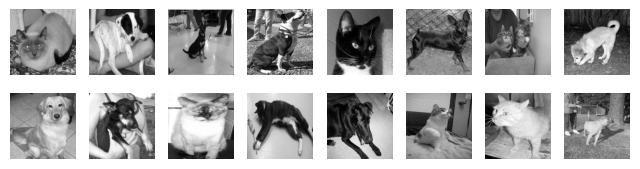

In [31]:
img = next(iter(train_loader))[0].squeeze(1).numpy()
cla = next(iter(train_loader))[1].numpy()

print(type(img), img.shape)
print(type(cla), cla.shape)

row, col = 2, 8

# 1번 방식
k = 0
fig, axes = plt.subplots(row, col, figsize=(8, 2))

for i in range(row):
    for j in range(col):
        ax = axes[i, j]
        ax.axis('off')
        ax.imshow(img[k], cmap='gray')
        k += 1

# 2번 방식
# k = 0
# plt.figure(figsize=(8, 2))

# for i in range(row):
#     for j in range(col):
#         plt.subplot(row, col, k + 1)
#         plt.imshow(img[k].squeeze(0), cmap='gray')
#         plt.axis('off')
#         k += 1

In [32]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=(2, 2)),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=(2, 2)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=1 * 224 * 224, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=class_num)
        )
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
# model = torchvision.models.vgg19(pretrained=False).to(device)
model=LeNet().to(device)
print(model)

summary(model, (1, 224, 224))

LeNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=50176, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=2, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 224, 224]             156
       BatchNorm2d-2          [-1, 6, 224, 22

In [33]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [34]:
t_data_len = len(train_data)
v_data_len = len(test_data)

t_t_loss, t_t_acc = [], []
t_v_loss, t_v_acc = [], []

w_t_loss = SummaryWriter('logs/' + date + '_' + time)
w_t_acc = SummaryWriter('logs/' + date + '_' + time)
w_v_loss = SummaryWriter('logs/' + date + '_' + time)
w_v_acc = SummaryWriter('logs/' + date + '_' + time)

for e in range(epoch):
    r_t_loss, r_t_acc = 0.0, 0.0
    r_v_loss, r_v_acc = 0.0, 0.0
    
    model.train()
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        r_t_loss += loss.item() * inputs.size(0)
        
        # pred, labels = outputs.cpu(), labels.cpu()
        # pred[pred >= 0.5] = 1
        # pred[pred < 0.5] = 0
        # r_t_acc += torch.sum(pred == labels).item()
        
        _, pred = torch.max(outputs, 1)
        r_t_acc += torch.sum(pred == labels).item()
    
    t_t_loss.append(r_t_loss / t_data_len)
    t_t_acc.append(r_t_acc / t_data_len)
    
    
    with torch.no_grad():
        model.eval()
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            r_v_loss += loss.item() * inputs.size(0)
            
            # pred, labels = outputs.cpu(), labels.cpu()
            # pred[pred >= 0.5] = 1
            # pred[pred < 0.5] = 0
            # r_v_acc += torch.sum(pred == labels).item()
            
            _, pred = torch.max(outputs, 1)
            r_v_acc += torch.sum(pred == labels).item()
    
    t_v_loss.append(r_v_loss / v_data_len)
    t_v_acc.append(r_v_acc / v_data_len)
        
    print(
        f'{datetime.now().time().replace(microsecond=0)} -- '
        f'epoch : {e + 1}\n'
        f'train_loss : {t_t_loss[e]:.4f}\ttrain_acc : {t_t_acc[e] * 100:.2f}%\n'
        f'val_loss : {t_v_loss[e]:.4f}\tval_acc : {t_v_acc[e] * 100:.2f}%'
    )
    
    w_t_loss.add_scalar('train_loss', t_t_loss[e], e + 1)
    w_t_acc.add_scalar('train_acc', t_t_acc[e], e + 1)
    w_v_loss.add_scalar('val_loss', t_v_loss[e], e + 1)
    w_v_acc.add_scalar('val_acc', t_v_acc[e], e + 1)
    
w_t_loss.close()
w_t_acc.close()
w_v_loss.close()
w_v_acc.close()

100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


14:53:08 -- epoch : 1
train_loss : 0.6426	train_acc : 62.14%
val_loss : 0.6406	val_acc : 62.82%


100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


14:53:51 -- epoch : 2
train_loss : 0.5860	train_acc : 68.84%
val_loss : 0.6301	val_acc : 64.02%


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


14:54:36 -- epoch : 3
train_loss : 0.5654	train_acc : 70.52%
val_loss : 0.5803	val_acc : 68.54%


100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


14:55:20 -- epoch : 4
train_loss : 0.5095	train_acc : 75.22%
val_loss : 0.5586	val_acc : 70.20%


100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


14:56:07 -- epoch : 5
train_loss : 0.4734	train_acc : 78.03%
val_loss : 0.5543	val_acc : 70.62%


100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


14:56:52 -- epoch : 6
train_loss : 0.4344	train_acc : 80.51%
val_loss : 0.5724	val_acc : 70.16%


100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


14:57:36 -- epoch : 7
train_loss : 0.4127	train_acc : 81.32%
val_loss : 0.5463	val_acc : 72.04%


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


14:58:20 -- epoch : 8
train_loss : 0.3682	train_acc : 84.69%
val_loss : 0.5396	val_acc : 72.62%


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


14:59:04 -- epoch : 9
train_loss : 0.3433	train_acc : 85.59%
val_loss : 0.5550	val_acc : 71.82%


100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

14:59:47 -- epoch : 10
train_loss : 0.3083	train_acc : 87.86%
val_loss : 0.5392	val_acc : 73.74%


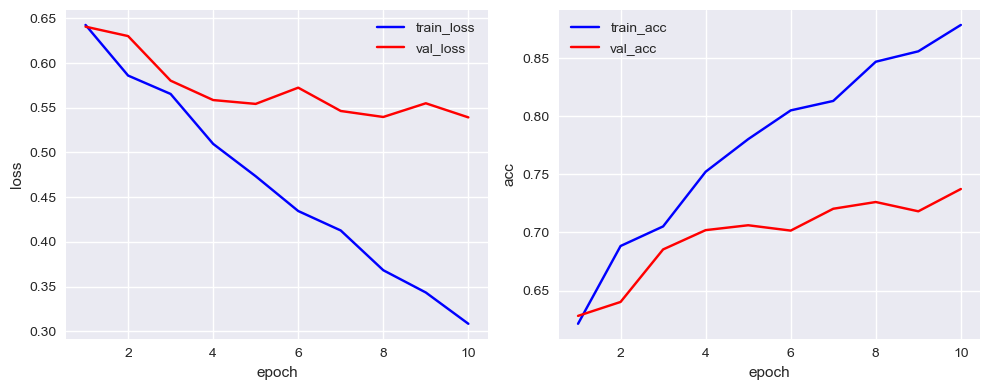

In [35]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epoch + 1), t_t_loss, 'b', label='train_loss')
plt.plot(range(1, epoch + 1), t_v_loss, 'r', label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epoch + 1), t_t_acc, 'b', label='train_acc')
plt.plot(range(1, epoch + 1), t_v_acc, 'r', label='val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()

plt.tight_layout()